In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Building from yesterday

In [4]:
url = "https://raw.githubusercontent.com/pedroteche-ih/DAFT_MEX_202209/main/data/tb_ames_housing.csv"
tb_housing = pd.read_csv(url)
tb_housing.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

## NA Treatment

In [5]:
tb_housing.isna().sum().sort_values(ascending=False).head(10)


PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageCond        81
GarageType        81
GarageFinish      81
dtype: int64

In [6]:
tb_housing["FireplaceQu"].value_counts()

Gd    380
TA    313
Fa     33
Ex     24
Po     20
Name: FireplaceQu, dtype: int64

In [7]:
tb_housing.shape[0] * 0.5

730.0

In [8]:
# Fill FireplaceQu for houses with no fireplace
tb_housing["FireplaceQu"] = tb_housing["FireplaceQu"].fillna("NF")
# Dropping columns with over 50% missing values
tb_housing = tb_housing.dropna(axis=1, thresh=tb_housing.shape[0] * 0.5)


In [10]:
tb_housing["MSZoning"].value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

## Variable Transformation

In [11]:
def var_trans(data):
    # Calculating logs
    data["log_SalePrice"] = np.log(data["SalePrice"])
    data["log_GrLivArea"] = np.log(data["GrLivArea"])
    # Feature creation through interaction
    data["lot_ocuppation"] = data["GrLivArea"] / data["LotArea"]

    heatingqc_group = {
        "Ex": "Good",
        "Gd": "Good",
        "TA": "Bad",
        "Fa": "Bad",
        "Po": "Bad",
    }
    data["grp_HeatingQC"] = data["HeatingQC"].map(heatingqc_group)
    
    mszoning_group = {"RL": "RL", "RM": "RM"}
    data["grp_MSZoning"] = data["MSZoning"].map(mszoning_group)
    data["grp_MSZoning"] = data["grp_MSZoning"].fillna("Other")

    return data


In [12]:
tb_housing_trans = var_trans(tb_housing)


In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder


In [15]:
def transformer_fit(train_data):
    # Fitting Scaler
    scaler = StandardScaler()
    scaler.fit(train_data[["log_GrLivArea", "OverallQual", "lot_ocuppation"]])

    # Fitting OneHotEncoder
    ohe = OneHotEncoder(drop="first", sparse=False, handle_unknown="ignore")
    ohe.fit(train_data[["grp_HeatingQC", "grp_MSZoning"]])

    return scaler, ohe


def transformer_apply(data, scaler, ohe):
    # Applying scaler
    feature_names = ["sca_" + name for name in scaler.feature_names_in_]
    
    scaled_matrix = scaler.transform(
        data[["log_GrLivArea", "OverallQual", "lot_ocuppation"]]
    )
    scaled_data = pd.DataFrame(scaled_matrix, columns=feature_names)

    # Applying OHE
    dummy_names = ohe.get_feature_names_out()
    ohe_matrix = ohe.transform(data[["grp_HeatingQC", "grp_MSZoning"]])
    dummy_data = pd.DataFrame(ohe_matrix, columns=dummy_names)

    return pd.concat([scaled_data, dummy_data], axis=1)


In [16]:
tb_housing_trans = var_trans(tb_housing)
x_var = [
    "log_GrLivArea",
    "OverallQual",
    "lot_ocuppation",
    "grp_HeatingQC",
    "grp_MSZoning",
]
y_var = "log_SalePrice"
model_var = x_var + [y_var]
print(model_var)

['log_GrLivArea', 'OverallQual', 'lot_ocuppation', 'grp_HeatingQC', 'grp_MSZoning', 'log_SalePrice']


In [17]:
tb_housing_model = tb_housing_trans[model_var].dropna()

X = tb_housing_model[x_var]
y = tb_housing_model[y_var]

X_train, X_test, y_train, y_test = train_test_split(X, y)

scaler, ohe = transformer_fit(X_train)

X_train_trans = transformer_apply(X_train, scaler, ohe)
X_test_trans = transformer_apply(X_test, scaler, ohe)


In [21]:
X_train_trans.shape


(1095, 6)

# Non-Linear Techniques - Regression

## Baseline Model - Linear Regression

In [22]:
from sklearn.linear_model import LinearRegression


In [23]:
lm_fit = LinearRegression()
lm_fit.fit(X_train_trans, y_train)


LinearRegression()

In [33]:
y_pred = lm_fit.predict(X_test_trans)

tb_test = pd.DataFrame({"y_real": y_test, "y_pred": y_pred})
tb_test = pd.concat([tb_test, X_test], axis=1)

tb_test["SalePrice"] = np.exp(tb_test["y_real"])
tb_test["pred_lm_SalePrice"] = np.exp(tb_test["y_pred"])
tb_test

,y_real,y_pred,log_GrLivArea,OverallQual,lot_ocuppation,grp_HeatingQC,grp_MSZoning,SalePrice,pred_lm_SalePrice
166,12.154779,12.023488,7.532088,5,0.174356,Good,RL,190000.0,166622.825390
454,12.144197,11.909262,7.454720,5,0.185866,Bad,RL,188000.0,148636.909826
329,11.264464,11.594210,7.083388,5,0.186192,Bad,RM,78000.0,108467.980203
1292,11.585246,11.835109,7.771489,5,0.359394,Bad,RM,107500.0,138013.812765
970,11.813030,11.617779,7.083388,4,0.110370,Bad,RL,135000.0,111054.764618
...,...,...,...,...,...,...,...,...,...
1356,11.608236,11.652971,6.793466,5,0.094123,Bad,RL,110000.0,115032.597717
1074,12.175613,12.166841,7.122867,7,0.144928,Good,RL,194000.0,192305.525616
1107,12.523526,12.397918,7.611348,7,0.086899,Good,RL,274725.0,242296.641924
1433,12.136187,12.161132,7.491088,6,0.174642,Good,RL,186500.0,191210.869765


In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [26]:
np.sqrt(mean_squared_error(tb_test["SalePrice"], tb_test["pred_lm_SalePrice"]))


40476.63653425779

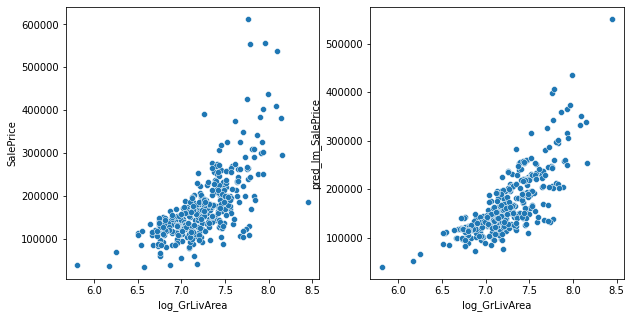

In [40]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
sns.scatterplot(data = tb_test, x = 'log_GrLivArea', y = 'SalePrice', ax = ax[0])
sns.scatterplot(data = tb_test, x = 'log_GrLivArea', y = 'pred_lm_SalePrice', ax = ax[1])

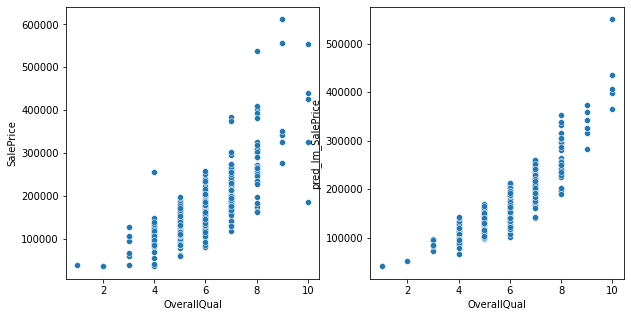

In [41]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
sns.scatterplot(data = tb_test, x = 'OverallQual', y = 'SalePrice', ax = ax[0])
sns.scatterplot(data = tb_test, x = 'OverallQual', y = 'pred_lm_SalePrice', ax = ax[1])

# kNN

**Hyper-parameters:**

1. `n_neighbors` - number of k nearest neighbors used to build model.
1. `weights` - `"uniform"` or `"distance"`, how neighbor values are weighed.

In [42]:
from sklearn.neighbors import KNeighborsRegressor


In [55]:
knn_fit = KNeighborsRegressor(n_neighbors=1)
knn_fit.fit(X_train_trans, y_train)


KNeighborsRegressor(n_neighbors=15)

In [56]:
y_pred = knn_fit.predict(X_test_trans)


In [57]:
2.718 ** 12

162552.4160011032

In [44]:
tb_test["pred_1nn_SalePrice"] = np.exp(y_pred)
tb_test


,y_real,y_pred,log_GrLivArea,OverallQual,lot_ocuppation,grp_HeatingQC,grp_MSZoning,SalePrice,pred_lm_SalePrice,pred_1nn_SalePrice
166,12.154779,12.023488,7.532088,5,0.174356,Good,RL,190000.0,166622.825390,137000.0
454,12.144197,11.909262,7.454720,5,0.185866,Bad,RL,188000.0,148636.909826,126000.0
329,11.264464,11.594210,7.083388,5,0.186192,Bad,RM,78000.0,108467.980203,100000.0
1292,11.585246,11.835109,7.771489,5,0.359394,Bad,RM,107500.0,138013.812765,136000.0
970,11.813030,11.617779,7.083388,4,0.110370,Bad,RL,135000.0,111054.764618,137500.0
...,...,...,...,...,...,...,...,...,...,...
1356,11.608236,11.652971,6.793466,5,0.094123,Bad,RL,110000.0,115032.597717,122000.0
1074,12.175613,12.166841,7.122867,7,0.144928,Good,RL,194000.0,192305.525616,178000.0
1107,12.523526,12.397918,7.611348,7,0.086899,Good,RL,274725.0,242296.641924,242000.0
1433,12.136187,12.161132,7.491088,6,0.174642,Good,RL,186500.0,191210.869765,165150.0


In [48]:
np.round(
    np.sqrt(mean_squared_error(tb_test["SalePrice"], tb_test["pred_1nn_SalePrice"])), 2
)


45771.89

In [49]:
np.round(
    np.sqrt(mean_squared_error(tb_test["SalePrice"], tb_test["pred_lm_SalePrice"])), 2
)

40476.64

## Optimizing KNN

In [54]:
n_k = [1, 5, 10, 25, 50]
for k in n_k:
    knn_fit = KNeighborsRegressor(n_neighbors=k, weights="distance")
    knn_fit.fit(X_train_trans, y_train)


    y_pred = knn_fit.predict(X_test_trans)

    error = np.round(
        np.sqrt(mean_squared_error(tb_test["SalePrice"], np.exp(y_pred))), 2
    )

    print(f"{k}-NN RMSE: {error}")


1-NN RMSE: 45771.89
5-NN RMSE: 38403.67
10-NN RMSE: 38300.68
25-NN RMSE: 37716.27
50-NN RMSE: 38968.9


In [ ]:
# Back at 11h10!

# Decision Trees

**Hyperparameters:**
1. `max_depth`: maximum depth of tree
1. `min_samples_leaf`: minimum number of training points at each leaf
1. `min_samples_split`: minimum number of training points at each branch

In [58]:
from sklearn.tree import DecisionTreeRegressor


In [59]:
dt_fit = DecisionTreeRegressor()
dt_fit.fit(X_train_trans, y_train)


DecisionTreeRegressor()

In [60]:
y_pred = dt_fit.predict(X_test_trans)
tb_test["pred_dt_SalePrice"] = np.exp(y_pred)


In [61]:
np.round(
    np.sqrt(mean_squared_error(tb_test["SalePrice"], tb_test["pred_dt_SalePrice"])), 2
)


50899.72

## Checking for Overfitting

In [62]:
dt_fit.get_depth()


24

In [64]:
y_train_pred = dt_fit.predict(X_train_trans)
np.sqrt(mean_squared_error(np.exp(y_train), np.exp(y_train_pred)))


814.1609967014682

## Correcting Overfit Decision Trees

A decision tree's complexity is directly proportional to the amount of overfitting: more complex trees will have a higher probability of overfitting compared to simples trees.

Let's limit our tree's complexity using our 3 hyperparameters:

1. The deeper a tree (**larger `max_depth`**), the **more complex** the tree;
1. The smaller the leafs (**smaller `min_samples_leaf`**), the **more complex** the tree;
1. The smaller the branches (**smaller `min_samples_split`**), the **more complex** the tree;

The easiest way to reduce a tree's complexity is by training trees of smaller `max_depth`:

In [66]:
dt_fit = DecisionTreeRegressor(max_depth=5)
dt_fit.fit(X_train_trans, y_train)
y_pred = dt_fit.predict(X_test_trans)
tb_test["pred_dt_SalePrice"] = np.exp(y_pred)
np.round(
    np.sqrt(mean_squared_error(tb_test["SalePrice"], tb_test["pred_dt_SalePrice"])), 2
)


43511.62

We can use **nested loops** to test different hyperparameters:

In [67]:
len(list(range(10, 201, 5))) * len(list(range(1, 50, 5))) * len(list(range(2, 100, 5)))


7800

In [71]:
max_depth_list = range(10, 201, 5)
min_samples_leaf_list = range(1, 50, 5)
min_samples_split_list = range(2, 100, 5)
errors = []
for depth in max_depth_list:
    for leaf in min_samples_leaf_list:
        for split in min_samples_split_list:
            dt_fit = DecisionTreeRegressor(
                max_depth=depth, min_samples_leaf=leaf, min_samples_split=split
            )
            dt_fit.fit(X_train_trans, y_train)
            y_pred = dt_fit.predict(X_test_trans)
            error_test = np.round(
                np.sqrt(
                    mean_squared_error(
                        tb_test["SalePrice"], np.exp(y_pred)
                    )
                ),
                2,
            )

            y_pred = dt_fit.predict(X_train_trans)
            error_train = np.round(
                np.sqrt(
                    mean_squared_error(
                        np.exp(y_train), np.exp(y_pred)
                    )
                ),
                2,
            )
            
            errors.append((depth, leaf, split, error_test, error_train))


In [74]:
error_simul = pd.DataFrame(errors, columns=["depth", "leaf", "split", "error_test", "error_train"]).sort_values("error_test")


In [76]:
error_simul['test_accuracy'] = 1/error_simul['error_test']
error_simul['train_accuracy'] = 1/error_simul['error_train']

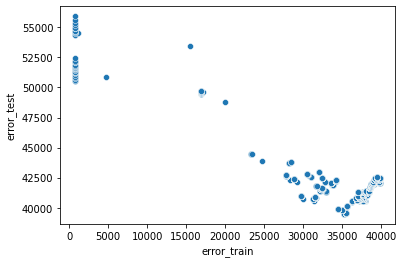

In [78]:
sns.scatterplot(data = error_simul, x = 'error_train', y = 'error_test')

## Visualizing the Tree


In [79]:
from sklearn.tree import plot_tree, export_graphviz

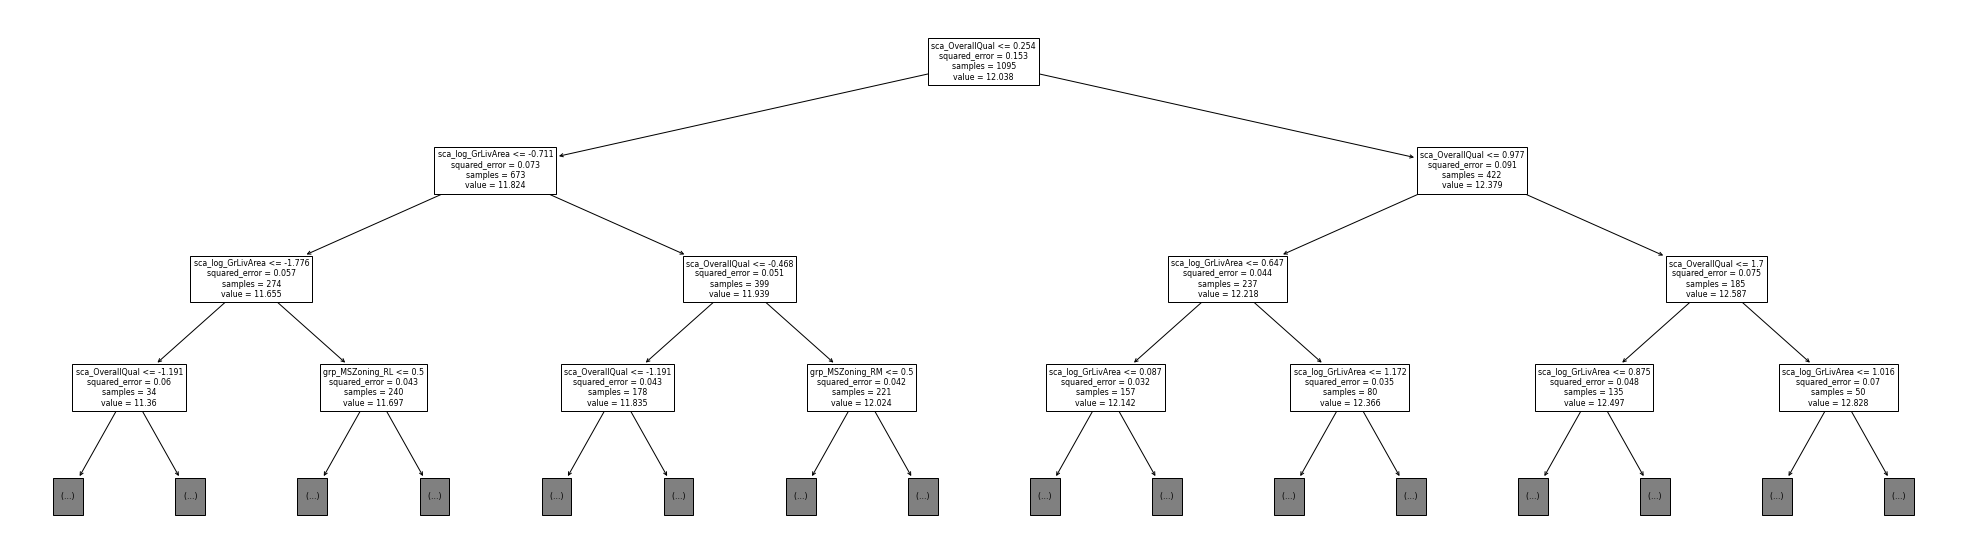

In [82]:
dt_fit = DecisionTreeRegressor(max_depth= 6, min_samples_leaf = 13, min_samples_split = 28)
dt_fit.fit(X_train_trans, y_train)
plt.figure(figsize = (35, 10))
plot_tree(dt_fit, feature_names=X_train_trans.columns, max_depth = 3);

In [83]:
export_graphviz(dt_fit, 'teste.dot', feature_names=X_train_trans.columns)

# Ensemble Methods

Alongside deep-learning methods, ensemble algorithms are currently the best tools available for predictive modelling. They have the precision associated with decision trees, while adopting several strategies to mitigate the overfitting risk.

Let's see the two main methods of ensemble regressors: bagging and boosting.

## Bagging

**RandomForestRegressor Hyperparameters**:

1. `n_estimators`: number of weak learners (the more weak learners, the more complex the model);
1. `max_depth`: complexity of each weak learner (the more complex each weak learner, the more complex the model); 

In [84]:
from sklearn.ensemble import RandomForestRegressor


In [110]:
rf_fit = RandomForestRegressor(n_estimators=1000, max_depth=16)  # RandomStumps
rf_fit.fit(X_train_trans, y_train)


RandomForestRegressor(max_depth=16, n_estimators=1000)

In [111]:
y_pred = rf_fit.predict(X_test_trans)
tb_test["pred_rf_SalePrice"] = np.exp(y_pred)


In [112]:
np.round(
    np.sqrt(mean_squared_error(tb_test["SalePrice"], tb_test["pred_rf_SalePrice"])), 2
)


42938.76

## Optimizing w/ GridSearch

In [113]:
from sklearn.model_selection import GridSearchCV


In [114]:
range(10, 1001, 50)

range(10, 1001, 50)

In [118]:
hyper_parameters = {"n_estimators": range(10, 1001, 200), "max_depth": range(1, 20, 5)}
rf_fit = RandomForestRegressor()
cv_rf_fit = GridSearchCV(rf_fit, hyper_parameters, n_jobs=-1)


In [119]:

cv_rf_fit.fit(X_train_trans, y_train)


GridSearchCV(estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': range(1, 20, 5),
                         'n_estimators': range(10, 1001, 200)})

In [120]:
cv_rf_fit.best_estimator_


RandomForestRegressor(max_depth=6, n_estimators=210)

In [121]:
y_pred = cv_rf_fit.predict(X_test_trans)
tb_test["pred_rf_SalePrice"] = np.exp(y_pred)
np.round(
    np.sqrt(mean_squared_error(tb_test["SalePrice"], tb_test["pred_rf_SalePrice"])), 2
)


41451.78

## Boosting

### Cat Boosting!

In [122]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.2 MB/s 


In [124]:
import catboost as cat


In [130]:
cat_fit = cat.CatBoost (iterations=20000, depth=5, od_type="Iter", od_wait=500, verbose = False)


In [131]:
cat_fit.fit(X_train_trans, y_train, eval_set=(X_test_trans, y_test))

In [132]:
y_pred = cat_fit.predict(X_test_trans)
tb_test["pred_cat_SalePrice"] = np.exp(y_pred)
np.round(
    np.sqrt(mean_squared_error(tb_test["SalePrice"], tb_test["pred_cat_SalePrice"])), 2
)


37863.19

# Including more Variables

In [133]:
tb_housing_trans.select_dtypes(include="number").columns[
    np.abs(tb_housing_trans.corr()["SalePrice"]).sort_values() > 0.2
]

Index(['GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice', 'log_SalePrice', 'log_GrLivArea',
       'lot_ocuppation'],
      dtype='object')

In [141]:
tb_housing_trans = var_trans(tb_housing)
x_var = [
    "log_GrLivArea",
    "OverallQual",
    "LowQualFinSF",
    "GrLivArea",
    "BsmtFullBath",
    "BsmtHalfBath",
    "FullBath",
    "HalfBath",
    "BedroomAbvGr",
    "KitchenAbvGr",
    "TotRmsAbvGrd",
    "Fireplaces",
    "GarageYrBlt",
    "GarageCars",
    "GarageArea",
    "WoodDeckSF",
    "OpenPorchSF",
    "EnclosedPorch",
    "3SsnPorch",
    "ScreenPorch",
    "PoolArea",
    "MiscVal",
    "lot_ocuppation"
]
y_var = "log_SalePrice"
model_var = x_var + [y_var]
tb_housing_model = tb_housing_trans[model_var].dropna()

X = tb_housing_model[x_var]
y = tb_housing_model[y_var]
X_train, X_test, y_train, y_test = train_test_split(X, y)


In [142]:
lm_fit = LinearRegression()
lm_fit.fit(X_train, y_train)
y_pred = lm_fit.predict(X_test)
np.sqrt(mean_squared_error(np.exp(y_test), np.exp(y_pred)))

29099.281244498135

In [145]:
cat_fit = cat.CatBoostRegressor(iterations=20000, depth=2, od_type="Iter", od_wait=1500, verbose = False)
cat_fit.fit(X_train, y_train, eval_set=(X_test, y_test))

In [146]:
y_pred = cat_fit.predict(X_test)
np.sqrt(mean_squared_error(np.exp(y_test), np.exp(y_pred)))

28645.80467845333

In [147]:
# Cya in 1h30!